In [2]:
from transformers import AutoImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np
import tensorflow as tf
from transformers import YolosImageProcessor, YolosForObjectDetection


## YOLO

In [2]:
image = Image.open("./foot/2.1.jpeg")

In [3]:
model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# model predicts bounding boxes and corresponding COCO classes
logits = outputs.logits
bboxes = outputs.pred_boxes


# print results
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Detected person with confidence 0.961 at location [181.73, 267.06, 461.19, 1016.29]


In [6]:
model

YolosForObjectDetection(
  (vit): YolosModel(
    (embeddings): YolosEmbeddings(
      (patch_embeddings): YolosPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
      (interpolation): InterpolateInitialPositionEmbeddings()
    )
    (encoder): YolosEncoder(
      (layer): ModuleList(
        (0-11): 12 x YolosLayer(
          (attention): YolosAttention(
            (attention): YolosSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): YolosSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
        

### Real Time

In [1]:
from ultralytics import YOLO


In [3]:
model = YOLO('yolov8n.yaml').load('yolov8n.pt')  # build from YAML and transfer weights



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1     37248  ultralytics.nn.modules.block.C2f             [192, 64, 1]                  
 16                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 

WARNING ⚠️ 'source' is missing. Using 'source=/home/kakas/anaconda3/lib/python3.11/site-packages/ultralytics/assets'.


[ WARN:0@42.331] global cap_v4l.cpp:997 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@42.333] global obsensor_uvc_stream_channel.cpp:159 getStreamChannelGroup Camera index out of range



image 1/2 /home/kakas/anaconda3/lib/python3.11/site-packages/ultralytics/assets/bus.jpg: 640x480 4 0s, 1 5, 1 11, 302.1ms
image 2/2 /home/kakas/anaconda3/lib/python3.11/site-packages/ultralytics/assets/zidane.jpg: 384x640 2 0s, 1 27, 158.2ms
Speed: 20.2ms preprocess, 230.2ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


TypeError: Image data of dtype object cannot be converted to float

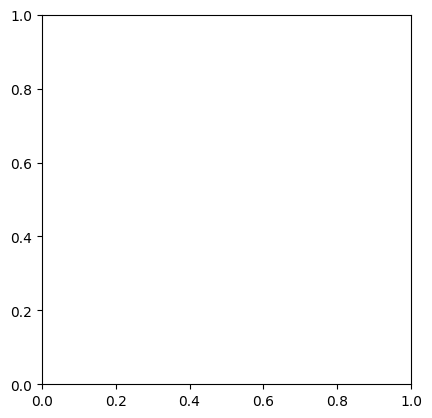

In [5]:
def draw_boxes(image, boxes):
    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Extract the bounding box coordinates from the 'xyxy' attribute
    box_coordinates = boxes.xyxy.cpu().numpy()

    # Plot the bounding boxes
    for box in box_coordinates:
        x_min, y_min, x_max, y_max = box[:4]
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Show the plot
    plt.show()

# Open the camera
cap = cv2.VideoCapture(0)  # Use 0 for the default camera, you can change it to the appropriate camera index

while True:
    # Capture a frame from the camera
    ret, frame = cap.read()

    # Convert the OpenCV BGR image to RGB
    rgb_frame = frame#cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame using your detection model
    results = model(rgb_frame)  # Replace 'detect' with the actual method for inference in your detection model

    # Draw bounding boxes on the frame
    draw_boxes(rgb_frame, results[0].boxes)  # Assuming there's only one result in real-time

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close the window
cap.release()
cv2.destroyAllWindows()

In [4]:
cap = cv2.VideoCapture(0)  # Use 0 for the default camera, you can change it to the appropriate camera index

while cap.isOpened():
    # Capture a frame from the camera
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the OpenCV BGR image to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame using your detection model
    results = model(rgb_frame)  # Replace 'detect' with the actual method for inference in your detection model

    # Extract the bounding box coordinates from the 'xyxy' attribute
    box_coordinates = results[0].boxes.xyxy.cpu().numpy()

    # Draw bounding boxes on the frame
    for box in box_coordinates:
        x_min, y_min, x_max, y_max = box[:4]
        cv2.rectangle(frame, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255, 0, 0), 2)  # Draw a red rectangle

    # Display the frame with bounding boxes
    cv2.imshow('Object Detection', frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close the window
cap.release()
cv2.destroyAllWindows()


0: 480x640 1 0, 235.2ms
Speed: 7.5ms preprocess, 235.2ms inference, 11.8ms postprocess per image at shape (1, 3, 480, 640)


qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/kakas/anaconda3/lib/python3.11/site-packages/cv2/qt/plugins"


In [4]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to RGB
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame with the YOLOS model
    inputs = image_processor(images=torch.as_tensor(image), return_tensors="pt")
    outputs = model(**inputs)

    # Extract bounding box information
    target_sizes = torch.tensor([image.shape[:2]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]

    # Draw bounding boxes on the frame
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        label_str = model.config.id2label[label.item()]
        confidence_str = f"{round(score.item(), 3)}"
        cv2.rectangle(frame, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
        cv2.putText(frame, f"{label_str}: {confidence_str}", (int(box[0]), int(box[1]) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the resulting frame
    cv2.imshow('Object Detection', frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close all windows
cap.release()
cv2.destroyAllWindows()

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/kakas/anaconda3/lib/python3.11/site-packages/cv2/qt/plugins"


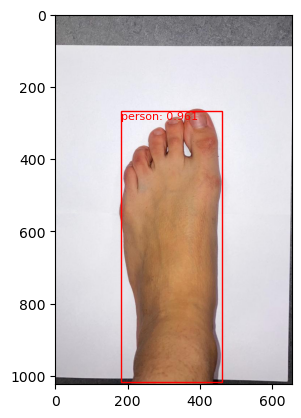

In [12]:
fig, ax = plt.subplots(1)
ax.imshow(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]

    # Create a Rectangle patch
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor="r", facecolor="none")

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Display label and confidence
    label_text = f"{model.config.id2label[label.item()]}: {round(score.item(), 3)}"
    ax.text(box[0], box[1], label_text, color="r", fontsize=8, verticalalignment="top")

plt.show()

## Capture Image

In [2]:
cap = cv2.VideoCapture(0)

while True:
    # Capture a frame
    ret, frame = cap.read()

    # Resize the frame to fit the specified width and height

    # Display the resized frame
    cv2.imshow("Camera", frame)

    # Wait for the user to press the 'Enter' key to capture the image
    if cv2.waitKey(1) == 13:  # 13 is the ASCII code for 'Enter'
        # Save the captured image
        cv2.imwrite("captured_image.jpeg", frame)
        break

# Release the camera
cap.release()

# Close the OpenCV window
cv2.destroyAllWindows()

qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/kakas/anaconda3/lib/python3.11/site-packages/cv2/qt/plugins"


## DETR

In [2]:
image_path = './captured_image.jpeg'

In [3]:
image = Image.open(image_path) #7.1.jpeg works as well as 2.jpeg, 14.2.jpeg, 2.3.4.jpeg, 8.4.jpeg

image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[
    0
]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Detected person with confidence 0.996 at location [-0.12, 115.62, 565.5, 351.93]


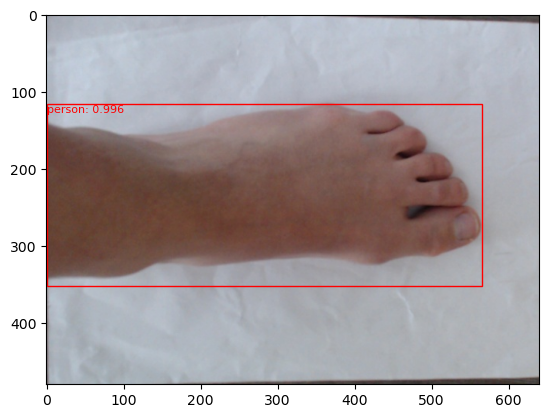

In [4]:
fig, ax = plt.subplots(1)
ax.imshow(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]

    # Create a Rectangle patch
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor="r", facecolor="none")

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Display label and confidence
    label_text = f"{model.config.id2label[label.item()]}: {round(score.item(), 3)}"
    ax.text(box[0], box[1], label_text, color="r", fontsize=8, verticalalignment="top")

plt.show()

## Calculate foot width category

In [6]:
box

[137.27, 133.92, 355.45, 686.64]

In [7]:
#box = [269.52, 439.47, 470.66, 1014.57]
width = box[2] - box[0]
width

218.17999999999998

In [51]:
""" opw = 210
oph = 297

imgpw = image.size[0]
imgph = image.size[1]

if imgpw > imgph:
    imgpw = image.size[1]
    imgph = image.size[0]
#box = fboundRect[2]
boxw = box[2] - box[0]
boxh = box[3] - box[1]

conversion_factor_width = opw / imgpw
conversion_factor_height = oph / imgph

# Calculate bounding box width and height in centimeters
boxw_cm = (boxw * conversion_factor_width) / 10
boxh_cm = (boxh * conversion_factor_height) / 10

print("Width of bounding box in centimeters: ", boxw_cm)
print("Height of bounding box in centimeters: ", boxh_cm) """



Width of bounding box in centimeters:  8.98269624573379
Height of bounding box in centimeters:  23.896442307692308


In [13]:
def calculateWidthCategory(boxh, boxw):
    ratio = boxw / boxh
    category = 'narrow'
    if ratio < 0.43:
        category = 'narrow'
    elif ratio < 0.48:
        category = 'medium'
    elif ratio > 0.48:
        category = 'wide'
    return category

In [14]:
boxw = box[2] - box[0]
boxh = box[3] - box[1]

if boxw > boxh:
    boxw = box[3] - box[1]
    boxh = box[2] - box[0]

In [7]:
print(boxw/ boxh)

0.41778932852445105


In [52]:
#print(boxw_cm/boxh_cm, boxw/boxh)

0.3759009868528523 0.4992564068516798


In [15]:

footWidth = calculateWidthCategory(boxh, boxw)

In [16]:
footWidth

'narrow'

## Detect foot edges

In [10]:
from sklearn.cluster import KMeans
from skimage.io import imread, imsave
import os

In [11]:
def kMeans_cluster(img):

    # For clustering the image using k-means, we first need to convert it into a 2-dimensional array
    # (H*W, N) N is channel = 3
    image_2D = img.reshape(img.shape[0]*img.shape[1], img.shape[2])

    # tweak the cluster size and see what happens to the Output
    kmeans = KMeans(n_clusters=2, random_state=0).fit(image_2D)
    clustOut = kmeans.cluster_centers_[kmeans.labels_]

    # Reshape back the image from 2D to 3D image
    clustered_3D = clustOut.reshape(img.shape[0], img.shape[1], img.shape[2])

    clusteredImg = np.uint8(clustered_3D*255)

    return clusteredImg

In [12]:
def edgeDetection(clusteredImage):
  #gray = cv2.cvtColor(hsvImage, cv2.COLOR_BGR2GRAY)
  edged1 = cv2.Canny(clusteredImage, 0, 255)
  edged = cv2.dilate(edged1, None, iterations=1)
  edged = cv2.erode(edged, None, iterations=1)
  return edged

In [13]:
def plotImage(img):  
    plt.imshow(img)
    plt.show()

In [14]:
img = imread(image_path)


In [15]:
clusteredImage = kMeans_cluster(img)

/home/kakas/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


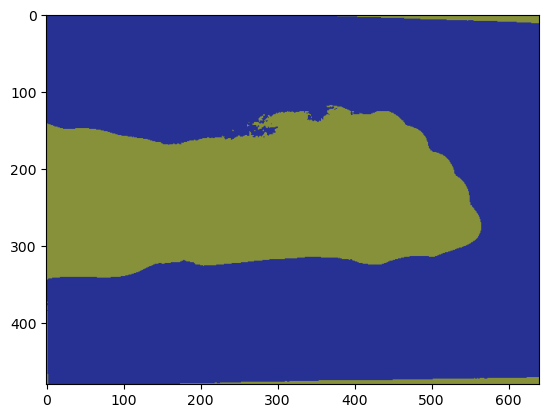

In [16]:
plotImage(clusteredImage)

In [17]:
edgedImg = edgeDetection(clusteredImage)

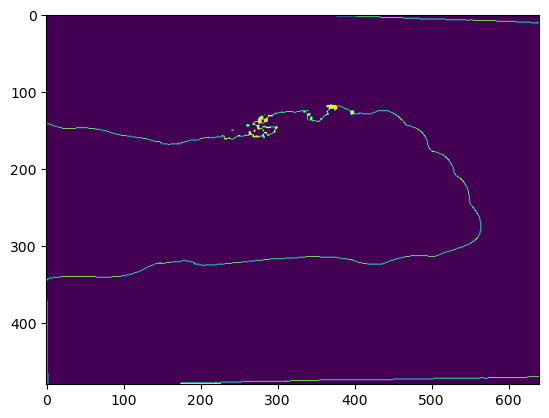

In [18]:
plotImage(edgedImg)

In [26]:
imsave('edged.jpg', edgedImg)

/tmp/ipykernel_12990/2826005943.py:1: UserWarning: edged.jpg is a low contrast image
  imsave('edged.jpg', edgedImg)


## Get foot shape

In [2]:
import tensorflow as tf

2023-12-16 18:08:57.116380: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-16 18:08:57.424469: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-16 18:08:57.426079: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-16 18:08:58.969882: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
model = tf.keras.models.load_model('footShapeANN80.h5')

2023-12-16 18:09:03.412556: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.
2023-12-16 18:09:03.462703: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.
2023-12-16 18:09:03.480023: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.
2023-12-16 18:09:03.894331: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.
2023-12-16 18:09:03.952093: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.


In [4]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 230400)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                14745664  
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 14745859 (56.25 MB)
Trainable params: 14745859 (56.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [40]:
edgedImg.shape

(687, 486)

In [22]:
def resize_image(image_path, target_size):
    # Open the image file
    with Image.open(image_path) as img:
        # Calculate the new dimensions while preserving the aspect ratio
        width, height = img.size
        aspect_ratio = width / height
        new_width = int(min(target_size[0], target_size[1] * aspect_ratio))
        new_height = int(min(target_size[1], target_size[0] / aspect_ratio))
        
        # Resize the image
        resized_img = img.resize((new_width, new_height))
        result = Image.new(img.mode, target_size)
        result.paste(resized_img, ((target_size[0] - new_width) // 2,
                                   (target_size[1] - new_height) // 2))
        
        return result

In [27]:
resized_image = resize_image('./edged.jpg', (480, 480))

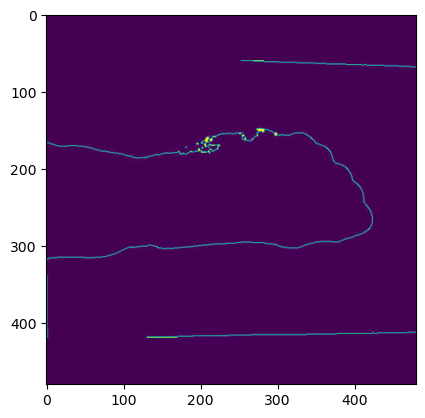

In [28]:
plotImage(resized_image)

In [29]:
img = (np.expand_dims(resized_image,0))


In [30]:
prediction = probability_model.predict(img)

1/1 [==============================] - 0s 128ms/step


In [31]:
prediction

array([[0.9813751 , 0.01614313, 0.00248182]], dtype=float32)

In [32]:
np.argmax(prediction) #0: egyptian, 1: greek, 2: roman, 

0

In [33]:
#decode prediction
def decodePrediction(prediction):
    if np.argmax(prediction) == 0:
        return 'egyptian'
    elif np.argmax(prediction) == 1:
        return 'greek'
    elif np.argmax(prediction) == 2:
        return 'roman'

In [34]:
footshape = decodePrediction(prediction)

In [35]:
footshape

'egyptian'

## Get suitable shoes

In [36]:
import pandas as pd

In [37]:
shoesdf = pd.read_csv('./climbingshoesdata.csv')

In [4]:
shoesdf

,Model,roman,greek,egyptian,narrow,medium,wide,beginner,intermediate,advanced,slabs,overhang,indoor,outdoor
0,Five Ten Moccasym,0,1,0,1,0,0,1,1,0,1,0,1,1
1,Five Ten Highangle,0,1,0,1,1,0,0,1,1,1,1,0,1
2,Five Ten Crawe,0,0,1,0,1,0,0,1,1,1,1,0,1
3,Scarpa Drago,0,1,1,0,1,0,0,0,1,0,1,1,0
4,Scarpa Instinct VS Men’s,0,1,0,0,1,1,0,1,1,1,1,0,1
5,Scarpa Furia Air,0,0,1,1,0,0,0,1,1,1,1,1,0
6,Scarpa Veloce Men’s,1,0,0,0,0,1,0,1,1,1,1,1,0
7,La Sportiva Katana,0,1,1,1,0,0,1,1,0,1,0,0,1
8,La Sportiva Miura,0,0,1,1,0,0,0,0,1,1,1,0,1
9,La Sportiva Futura,0,1,1,1,0,0,0,1,1,0,1,1,0


In [38]:
print(footshape, footWidth)

egyptian narrow


In [39]:
shoesdf.query(f'{footshape} == 1 & {footWidth} == 1')

,Model,roman,greek,egyptian,narrow,medium,wide,beginner,intermediate,advanced,slabs,overhang,indoor,outdoor
5,Scarpa Furia Air,0,0,1,1,0,0,0,1,1,1,1,1,0
7,La Sportiva Katana,0,1,1,1,0,0,1,1,0,1,0,0,1
8,La Sportiva Miura,0,0,1,1,0,0,0,0,1,1,1,0,1
9,La Sportiva Futura,0,1,1,1,0,0,0,1,1,0,1,1,0


## Capture Image

In [45]:
import cv2


In [52]:
""" 
def calculate_a4_size(width):
    height = int(width / 1.414)
    return width, height

def capture_image_with_a4_ratio(width):
    # Calculate A4 height based on the specified width
    width, height = calculate_a4_size(width)

    # Create a resizable window with the specified width and height
    cv2.namedWindow("Camera", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Camera", width, height)

    # Open the default camera (usually camera index 0)
    cap = cv2.VideoCapture(0)

    while True:
        # Capture a frame
        ret, frame = cap.read()

        # Resize the frame to fit the specified width and height
        frame = cv2.resize(frame, (width, height))

        # Display the resized frame
        cv2.imshow("Camera", frame)

        # Wait for the user to press the 'Enter' key to capture the image
        if cv2.waitKey(1) == 13:  # 13 is the ASCII code for 'Enter'
            # Save the captured image
            cv2.imwrite("captured_image.jpeg", frame)
            break

    # Release the camera
    cap.release()

    # Close the OpenCV window
    cv2.destroyAllWindows()

predetermined_width = 640
capture_image_with_a4_ratio(predetermined_width) """


QObject::moveToThread: Current thread (0x98331d0) is not the object's thread (0x33df93f0).
Cannot move to target thread (0x98331d0)

QObject::moveToThread: Current thread (0x98331d0) is not the object's thread (0x33df93f0).
Cannot move to target thread (0x98331d0)

QObject::moveToThread: Current thread (0x98331d0) is not the object's thread (0x33df93f0).
Cannot move to target thread (0x98331d0)

QObject::moveToThread: Current thread (0x98331d0) is not the object's thread (0x33df93f0).
Cannot move to target thread (0x98331d0)

QObject::moveToThread: Current thread (0x98331d0) is not the object's thread (0x33df93f0).
Cannot move to target thread (0x98331d0)

QObject::moveToThread: Current thread (0x98331d0) is not the object's thread (0x33df93f0).
Cannot move to target thread (0x98331d0)

QObject::moveToThread: Current thread (0x98331d0) is not the object's thread (0x33df93f0).
Cannot move to target thread (0x98331d0)

QObject::moveToThread: Current thread (0x98331d0) is not the object's